#Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
import sklearn
import imblearn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Important User Defined Functions

In [68]:
class detailedDataAnalysis(object):
  def __init__(self):
    pass

  def nullValuePercent(self, x):
    nullValueCheck = pd.DataFrame(x.isnull().sum()*100/x.shape[0])
    nullValueCheck.columns = ['NullPercent']
    return nullValueCheck

  def outlierCheck(self,ycol):
    iqr = ycol.quantile(q=0.75)-ycol.quantile(q=0.25)
    return len(ycol[ycol>ycol.quantile(q=0.75)+2*iqr]) + len(ycol[ycol<ycol.quantile(q=0.75)-2*iqr])

  def outlierRemove(self,ycol):
    iqr = ycol.quantile(q=0.75)-ycol.quantile(q=0.25)
    return ycol[(ycol<=ycol.quantile(q=0.75)+2*iqr) & (ycol>=ycol.quantile(q=0.75)-2*iqr)]

  def datasetSummary(self, y, todrop):
    x = y
    x = x.drop(columns=todrop)
    dict = {}
    dict['Number of Rows'] = x.shape[0]
    dict['Number of Columns'] = x.shape[1]
    dict['Number of Numeric Columns'] = x.select_dtypes(include = 'number').shape[1]
    dict['Number of Categorical Columns'] = x.select_dtypes(include = ['object','category','bool']).shape[1]
    dict['Number of date Columns'] = x.select_dtypes(include = ['datetime64']).shape[1]
    null_df = self.nullValuePercent(x)
    dict['Number of Columns with Complete Case'] = null_df[null_df.NullPercent==0].shape[0]
    dict['Number of Columns with <50% Missing Val'] = null_df[null_df.NullPercent<0.5].shape[0]
    dict['Number of Columns with >=50% Missing Val'] = null_df[null_df.NullPercent>=0.5].shape[0]
    dict['Number of Columns with >=90% Missing Val'] = null_df[null_df.NullPercent>=0.9].shape[0]
    dict['Pct of Columns with Complete Case'] = null_df[null_df.NullPercent==0].shape[0]*100/x.shape[1]
    dict['Pct of Columns with <50% Missing Val'] = null_df[null_df.NullPercent<0.5].shape[0]*100/x.shape[1]
    dict['Pct of Columns with >=50% Missing Val'] = null_df[null_df.NullPercent>=0.5].shape[0]*100/x.shape[1]
    dict['Pct of Columns with >=90% Missing Val'] = null_df[null_df.NullPercent>=0.9].shape[0]*100/x.shape[1]
    DataSumm = pd.DataFrame(dict,index=['Values'])
    return DataSumm.T

  def numericUnivariate(self,y,todrop):
    x = y.drop(todrop, axis=1)
    x = x.select_dtypes(include='number')
    numSumm = pd.DataFrame(x.describe()).T
    for col in x.columns:
      numSumm.loc[col,'10%'] = x[col].quantile(q=0.1)
      numSumm.loc[col,'90%'] = x[col].quantile(q=0.9)
      numSumm.loc[col,'99%'] = x[col].quantile(q=0.99)
      numSumm.loc[col,'Negatives'] = x[x[col]<0][col].shape[0]
      numSumm.loc[col,'Positives'] = x[x[col]>0][col].shape[0]
      numSumm.loc[col,'Zeros'] = x[x[col]==0][col].shape[0]
      numSumm.loc[col,'Uniques'] = x[col].nunique()
      numSumm.loc[col,'Outliers'] = self.outlierCheck(x[col])
      numSumm.loc[col,'Missing_Pct'] = x[col].isnull().sum()*100/x.shape[0]
      numSumm = numSumm[['count', 'Negatives', 'Positives', 'Uniques','Missing_Pct','Zeros', 'mean', 'std', 'min', '10%', '25%', '50%', '75%', '90%', '99%','max', 'Outliers']]
    return numSumm.round(2)

  def categoricalUnivariate(self,y,todrop):
    x = y.drop(todrop, axis=1)
    x = x.select_dtypes(include=['object','category','bool'])
    catSumm = pd.DataFrame()
    try:
      for col in x.columns:
        catSumm.loc[col,'Uniques'] = x[col].nunique()
        catSumm.loc[loc,'Missing_Pct'] = x[col].isnull().sum()*100/x.shape[0]
    except:
      pass
    return catSumm.round(2)

## ~Visualization : Later~

#unzip and load data

In [3]:
#Unizipping the data from google drive 
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/creditcardfraud.zip", 'r')
zip_ref.extractall("/content/drive/My Drive/Unzippeddata/creditcardfraud")
zip_ref.close()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [4]:
#reading the data from drive
df = pd.read_csv(r"/content/drive/My Drive/Unzippeddata/creditcardfraud/creditcard.csv", low_memory=False)
df.head()

#data_path = r"/Users/rahulsharma/Downloads/Data-Collisions.csv";
#df = pd.read_csv(data_path)
#df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Understanding Target Vairable

In [75]:
df['Class'].describe()

count    284807.000000
mean          0.001727
std           0.041527
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Class, dtype: float64

In [81]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [82]:
df['Class'].isnull().sum()

0

# Detailed Attributes Analysis

### Dataset Summary

In [69]:
getSummary = detailedDataAnalysis()
getSummary.datasetSummary(df,['Class'])

,Values
Number of Rows,284807.0
Number of Columns,30.0
Number of Numeric Columns,30.0
Number of Categorical Columns,0.0
Number of date Columns,0.0
Number of Columns with Complete Case,30.0
Number of Columns with <50% Missing Val,30.0
Number of Columns with >=50% Missing Val,0.0
Number of Columns with >=90% Missing Val,0.0
Pct of Columns with Complete Case,100.0


### Numerical Attributes

In [72]:
getSummary.numericUnivariate(df,['Class'])

,count,Negatives,Positives,Uniques,Missing_Pct,Zeros,mean,std,min,10%,25%,50%,75%,90%,99%,max,Outliers
Time,284807.0,0.0,284805.0,124592.0,0.0,2.0,94813.86,47488.15,0.00,35027.00,54201.50,84692.00,139320.50,157640.40,170560.94,172792.00,0.0
V1,284807.0,141456.0,143351.0,275663.0,0.0,0.0,0.00,1.96,-56.41,-1.89,-0.92,0.02,1.32,2.02,2.24,2.45,12259.0
V2,284807.0,134218.0,150589.0,275663.0,0.0,0.0,0.00,1.65,-72.72,-1.36,-0.60,0.07,0.80,1.33,3.80,22.06,17078.0
V3,284807.0,128163.0,156644.0,275663.0,0.0,0.0,-0.00,1.52,-48.33,-1.80,-0.89,0.18,1.03,1.68,2.73,9.38,8555.0
V4,284807.0,144105.0,140702.0,275663.0,0.0,0.0,0.00,1.42,-5.68,-1.66,-0.85,-0.02,0.74,1.48,4.25,16.88,14453.0
V5,284807.0,148928.0,135879.0,275663.0,0.0,0.0,-0.00,1.38,-113.74,-1.30,-0.69,-0.05,0.61,1.41,3.42,34.80,12201.0
V6,284807.0,176633.0,108174.0,275663.0,0.0,0.0,0.00,1.33,-26.16,-1.17,-0.77,-0.27,0.40,1.51,4.20,73.30,21938.0
V7,284807.0,135852.0,148955.0,275663.0,0.0,0.0,-0.00,1.24,-43.56,-1.08,-0.55,0.04,0.57,1.04,2.70,120.59,12158.0
V8,284807.0,135521.0,149286.0,275663.0,0.0,0.0,-0.00,1.19,-73.22,-0.46,-0.21,0.02,0.33,0.77,2.08,20.01,22916.0
V9,284807.0,149455.0,135352.0,275663.0,0.0,0.0,-0.00,1.10,-13.43,-1.29,-0.64,-0.05,0.60,1.30,2.99,15.59,14075.0


### Categorical Attributes

In [71]:
getSummary.categoricalUnivariate(df,['Class'])

""


### Correlation Analysis

In [101]:
corrmatrix = df.corr().round(2)
corrmatrix

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.00,0.12,-0.01,-0.42,-0.11,0.17,-0.06,0.08,-0.04,-0.01,0.03,-0.25,0.12,-0.07,-0.10,-0.18,0.01,-0.07,0.09,0.03,-0.05,0.04,0.14,0.05,-0.02,-0.23,-0.04,-0.01,-0.01,-0.01,-0.01
V1,0.12,1.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.23,-0.10
V2,-0.01,0.00,1.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.53,0.09
V3,-0.42,-0.00,0.00,1.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.21,-0.19
V4,-0.11,0.00,-0.00,-0.00,1.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.10,0.13
V5,0.17,0.00,-0.00,-0.00,-0.00,1.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.39,-0.09
V6,-0.06,0.00,0.00,0.00,-0.00,0.00,1.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.22,-0.04
V7,0.08,0.00,0.00,0.00,0.00,-0.00,0.00,1.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.40,-0.19
V8,-0.04,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,1.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.10,0.02
V9,-0.01,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,1.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.04,-0.10


In [102]:
corrmatrixUnstacked = corrmatrix.unstack().sort_values().drop_duplicates()
corrmatrixUnstacked.head(10)

V2      Amount   -0.53
V3      Time     -0.42
V5      Amount   -0.39
V17     Class    -0.33
Class   V14      -0.30
V12     Class    -0.26
Time    V11      -0.25
V25     Time     -0.23
Class   V10      -0.22
Amount  V3       -0.21
dtype: float64

# Handle Time Variable

In [123]:
#later

# Handle Amount Variable

In [124]:
#Needs to be Scaled
from sklearn.preprocessing import MinMaxScaler
df[['Amount']]= MinMaxScaler().fit_transform(df[['Amount']])
df[['Amount']].head()

,Amount
0,0.005824
1,0.000105
2,0.014739
3,0.004807
4,0.002724


# Train Test Split

In [117]:
y = df[['Class']]
x = df.drop(columns=['Class'])

In [118]:
print(x.shape, y.shape)

(284807, 30) (284807, 1)


In [119]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=111)
print(x_test.shape, y_test.shape,x_train.shape, y_train.shape)

(56962, 30) (56962, 1) (227845, 30) (227845, 1)


# Without Balancing: Random Forest

In [125]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, shuffle=False, random_state=None)
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
param_grid = {'n_estimators':[10,20,30,40,50]}
from sklearn.model_selection import GridSearchCV
rf = GridSearchCV(clf,param_grid=param_grid,cv=cv,verbose=True,n_jobs=-1)
rf.fit(x_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 16.6min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_s

0.9995962220427653
[[56856     5]
 [   18    83]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.94      0.82      0.88       101

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

0.9108471222423414


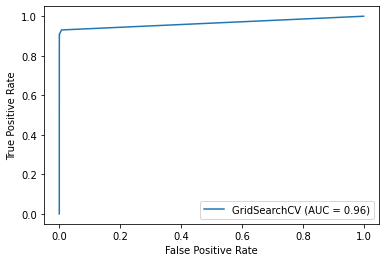

In [126]:
y_hat = rf.predict(x_test)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, plot_roc_curve
print(accuracy_score(y_test,y_hat))
print(confusion_matrix(y_test,y_hat))
print(classification_report(y_test,y_hat))
print(roc_auc_score(y_test,y_hat))
plot_roc_curve(rf,x_test,y_test)

# Balancing DataSet

### SMOTE

In [130]:
from imblearn.over_sampling import SMOTE
x_sm, y_sm = SMOTE().fit_resample(x,y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### UnderSampling

In [134]:
from imblearn.under_sampling import RandomUnderSampler
x_us, y_us = RandomUnderSampler().fit_resample(x,y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# Random Forest on Balanced Data : UnderSampling

(325, 30) (325, 1) (659, 30) (659, 1)
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0.9384615384615385
[[164   2]
 [ 18 141]]
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       166
           1       0.99      0.89      0.93       159

    accuracy                           0.94       325
   macro avg       0.94      0.94      0.94       325
weighted avg       0.94      0.94      0.94       325

0.9373721300295521


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


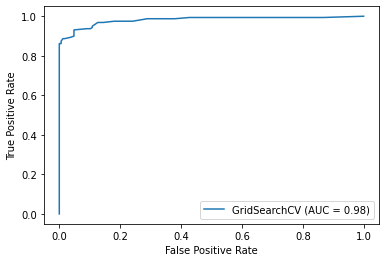

In [139]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_us,y_us,test_size=0.33,random_state=111)
print(x_test.shape, y_test.shape,x_train.shape, y_train.shape)
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, shuffle=False, random_state=None)
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
param_grid = {'n_estimators':[10,20,30,40,50]}
from sklearn.model_selection import GridSearchCV
rf = GridSearchCV(clf,param_grid=param_grid,cv=cv,verbose=True,n_jobs=-1)
rf.fit(x_train,y_train)
y_hat = rf.predict(x_test)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, plot_roc_curve
print(accuracy_score(y_test,y_hat))
print(confusion_matrix(y_test,y_hat))
print(classification_report(y_test,y_hat))
print(roc_auc_score(y_test,y_hat))
plot_roc_curve(rf,x_test,y_test)

# Random Forest on Balanced Data : OverSampling

(187648, 30) (187648,) (380982, 30) (380982,)
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 27.9min finished


0.9998454553206003
[[94015    26]
 [    3 93604]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     94041
           1       1.00      1.00      1.00     93607

    accuracy                           1.00    187648
   macro avg       1.00      1.00      1.00    187648
weighted avg       1.00      1.00      1.00    187648

0.9998457379801566


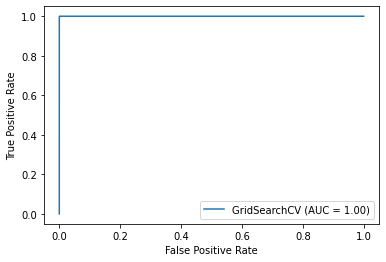

In [140]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_sm,y_sm,test_size=0.33,random_state=111)
print(x_test.shape, y_test.shape,x_train.shape, y_train.shape)
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, shuffle=False, random_state=None)
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
param_grid = {'n_estimators':[10,20,30,40,50]}
from sklearn.model_selection import GridSearchCV
rf = GridSearchCV(clf,param_grid=param_grid,cv=cv,verbose=True,n_jobs=-1)
rf.fit(x_train,y_train)
y_hat = rf.predict(x_test)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, plot_roc_curve
print(accuracy_score(y_test,y_hat))
print(confusion_matrix(y_test,y_hat))
print(classification_report(y_test,y_hat))
print(roc_auc_score(y_test,y_hat))
plot_roc_curve(rf,x_test,y_test)